Author: Cristian F. Zapata 

Email: cfzapatag@uqvirtual.edu.co

Description: This notebook makes a quantum mapping of a features vector  to then be represented in a photonic circuit through variational coding. This circuit is part of a photonic neural network based on probability density estimation.



## QFM for targetX

In [1]:
import numpy as np
import tensorflow as tf
from QuantumFMap import QuantumFMap

cutoff_dim = 3
modes = 2
r=0.5
vals = [0.2, 0.5, 0.3, 0.2, 0.5, 0.3] 
# normalize data
mini = np.min(vals)
maxi = np.max(vals)
vals = (vals - mini) / (maxi - mini)
vals=tf.convert_to_tensor(vals, tf.complex128) #features for QFM

quantum_state = QuantumFMap(cutoff_dim, modes, vals,r)
QFM=quantum_state.Squeezed_QFM
QFM

array([[ 9.41710616e-01+0.00000000e+00j, -3.07719176e-01+3.76847304e-17j,
         1.23150814e-01-3.01632500e-17j, -5.19515795e-02+1.90867007e-17j,
         2.24571622e-02-1.10008367e-17j, -9.84528344e-03+6.02849743e-18j,
         4.35598160e-03-3.20072335e-18j, -1.93975012e-03+1.66285614e-18j,
         8.67927640e-04-8.50323845e-19j],
       [ 9.41710616e-01+0.00000000e+00j,  3.07719176e-01-7.53694609e-17j,
         1.23150814e-01-6.03265000e-17j,  5.19515795e-02-3.81734013e-17j,
         2.24571622e-02-2.20016735e-17j,  9.84528344e-03-1.20569949e-17j,
         4.35598160e-03-6.40144671e-18j,  1.93975012e-03-3.32571229e-18j,
         8.67927640e-04-1.70064769e-18j],
       [ 9.41710616e-01+0.00000000e+00j, -1.53859588e-01-2.66492624e-01j,
        -6.15754069e-02+1.06651733e-01j,  5.19515795e-02-8.76685787e-17j,
        -1.12285811e-02-1.94484730e-02j, -4.92264172e-03+8.52626557e-03j,
         4.35598160e-03-1.51299797e-17j, -9.69875061e-04-1.67987288e-03j,
        -4.33963820e-04+7.51

## Weights

In [2]:
from WeightInitializer import WeightInitializer
# initialize varitional weights

weight_initializer = WeightInitializer(modes, layers)
weights = weight_initializer.initialize_weights()

In [3]:
weights_shape = weights.numpy().shape
weights_shape

(4, 18)

In [4]:
from init_weights import WeightInitializer
import numpy as np
import strawberryfields as sf
from strawberryfields import ops
import tensorflow as tf
import warnings
from itertools import combinations

warnings.filterwarnings("ignore")
physical_devices = tf.config.experimental.list_physical_devices('CPU')
tf.config.experimental.set_visible_devices(physical_devices[0])

#network paramet
layers = 4
hidden_units = 3 * modes

class photonic_circuit():
    def __init__(self, cutoff_dim, modes, r, layers, weights_shape):
        self.cutoff_dim = cutoff_dim
        self.modes = modes
        self.r = r
        self.layers = layers
        self.weights_shape = weights_shape

    def input_qnn_layer(self, hid, q):
        """
        Applies an input layer to a quantum neural network.

        This function introduces data to the QNN by applying a sequence
        of quantum gates to the input qumode.

        Args:
            hid (list): List of parameters for the quantum gates in the input layer.

        Returns:
            None
        """
        with tf.name_scope('inputlayer'):
            ops.Rgate(hid[0]) | q[0]
            ops.Rgate(hid[0]) | q[0]
            ops.Rgate(hid[0]) | q[0]

            ops.Rgate(hid[0]) | q[1]
            ops.Rgate(hid[0]) | q[1]
            ops.Rgate(hid[0]) | q[1]

    def qnn_layer(self, params, layer_number, q):
        with tf.name_scope('layer_{}'.format(layer_number)):
            N = len(q)
            M = int(self.modes * (self.modes - 1))

            int1 = params[:M]
            r1 = params[M:M + N]
            sm = params[M + N:M + 2 * N]
            sp = params[M + 2 * N:M + 3 * N]
            int2 = params[M + 3 * N:2 * M + 3 * N]
            r2 = params[2 * M + 3 * N:2 * M + 4 * N]
            r3 = params[2 * M + 4 * N:2 * M + 5 * N]
            r4 = params[2 * M + 5 * N:2 * M + 6 * N]

            theta1 = int1[:len(int1) // 2]
            phi1 = int1[len(int1) // 2:]

            theta2 = int2[:len(int2) // 2]
            phi2 = int2[len(int2) // 2:]

            for k, (q1, q2) in enumerate(combinations(q, 2)):
                ops.BSgate(theta1[k], phi1[k]) | (q1, q2)
            for i in range(N):
                ops.Rgate(r1[i]) | q[i]
            for i in range(N):
                ops.Sgate(sm[i], sp[i]) | q[i]
            for k, (q1, q2) in enumerate(combinations(q, 2)):
                ops.BSgate(theta2[k], phi2[k]) | (q1, q2)
            for i in range(N):
                ops.Rgate(r2[i]) | q[i]
            for i in range(N):
                ops.Rgate(r3[i]) | q[i]
            for i in range(N):
                ops.Rgate(r4[i]) | q[i]


    def build_circuit(self):
        global eng, qnn, sf_params, hid_params, layers

        num_params = np.prod(weights_shape)
        hidden_units = 3 * self.modes

        eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": self.cutoff_dim})
        qnn = sf.Program(self.modes)

        sf_params = np.arange(num_params).reshape(weights_shape).astype(str)
        sf_params = np.array([qnn.params(*i) for i in sf_params])

        hid_params = np.arange(num_params, num_params + hidden_units).reshape(hidden_units, 1).astype(str)
        hid_params = np.array([qnn.params(*i) for i in hid_params])

        with qnn.context as q:
            self.input_qnn_layer(hid_params, q)
            for k in range(self.layers):
                self.qnn_layer(sf_params[k], k, q)

    def circuit(self):
        # Call build_circuit to initialize the circuit
        self.build_circuit()
        return qnn  # Return the quantum circuit
    
# Create an instance of the photonic_circuit
_circuit = photonic_circuit(cutoff_dim, modes, r, layers, weights_shape)

# Access the circuit attribute
circuit= _circuit.circuit()

## VQMF

In [5]:
from QuantumEncoder import QuantumEncoder

In [8]:
quantum_encoder = QuantumEncoder(sf_params, hid_params, weights, eng, qnn)

result_state = quantum_encoder.state_VQFM(0.1)
result_state

tf.Tensor(
[ 0.98034537+0.01034567j  0.        +0.j          0.03274079+0.10629595j
  0.        +0.j         -0.04730676-0.14282586j  0.        +0.j
  0.02068131-0.03804809j  0.        +0.j          0.0097707 -0.00122372j], shape=(9,), dtype=complex128)


In [9]:
result_states = quantum_encoder.VQFM(tf.constant([0.1, 0.6]))
result_states

Cause: could not parse the source code of <function QuantumEncoder.VQFM.<locals>.<lambda> at 0x0000023B0EDD7100>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function QuantumEncoder.VQFM.<locals>.<lambda> at 0x0000023B0EDD7100>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


tf.Tensor(
[[ 0.98034537+0.01034567j  0.        +0.j          0.03274079+0.10629595j
   0.        +0.j         -0.04730676-0.14282586j  0.        +0.j
   0.02068131-0.03804809j  0.        +0.j          0.0097707 -0.00122372j]
 [ 0.98034537+0.01034567j  0.        +0.j          0.03274079+0.10629595j
   0.        +0.j         -0.04730676-0.14282586j  0.        +0.j
   0.02068131-0.03804809j  0.        +0.j          0.0097707 -0.00122372j]], shape=(2, 9), dtype=complex128)


## Cost function

In [10]:
def cost(vector_x, QFM):
    """
    Computes the mean infidelity between vectors with data.

    This function vectorizes the calculation of the infidelity between two vectors and
    returns the mean of a vector containing the infidelities between the vectors in the
    lists `vector_x` and `QFM`.

    Args:
        vector_x (tf.Tensor): List of vectors.
        QFM (tf.Tensor): Quantum Features map

    Returns:
        tf.Tensor: Mean infidelity between vectors.

    """

    def vectorized_infidelity(x, qfm):

        VQFM = QuantumEncoder(sf_params, hid_params, weights, eng, qnn).state_VQFM(x) 

        return tf.cast(1 - tf.abs(tf.reduce_sum(tf.multiply(VQFM, qfm))**2), tf.complex128)

    brakets = tf.map_fn(lambda args: vectorized_infidelity(*args), (vector_x, QFM), dtype=tf.complex128)
    return tf.reduce_mean(brakets)

optimizer = tf.keras.optimizers.Adam()


## Train

In [16]:

for i in range(10):
    with tf.GradientTape() as tape:
        loss=cost(vals, QFM)
        
    gradients=tape.gradient(loss,weights)
    optimizer.apply_gradients(zip([gradients],[weights]))
    
    if eng.run_progs:
        eng.reset()
    print("loss at iteration {} is {}".format(i,loss))

Cause: Unable to locate the source code of <bound method QuantumEncoder.state_VQFM of <__main__.QuantumEncoder object at 0x0000023B0F1CACD0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: source code not available
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <bound method QuantumEncoder.state_VQFM of <__main__.QuantumEncoder object at 0x0000023B0F1CACD0>>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimen

## Weights

In [35]:
f_weights = weights.numpy() 
f_weights

array([[-0.17044681, -0.28009075,  0.44576445,  0.25629726,  0.07857624,
        -0.00413211,  1.4734566 ,  0.34287104, -0.40738952,  0.4272938 ,
        -0.23721185, -0.25084937, -0.396545  ,  0.6219568 ,  0.34597802,
         0.30381832,  0.02841893, -0.0344738 ],
       [-0.40383583,  0.8025192 ,  0.03995593, -1.3548142 ,  0.00202642,
        -0.06344957,  1.3115318 ,  1.1135923 , -0.37666655,  0.5095239 ,
        -0.94399124,  1.5566835 , -0.8966981 , -1.7594165 ,  1.5227584 ,
         0.2299248 ,  0.06089553,  0.06770094],
       [ 1.0480129 ,  1.5481031 ,  0.43041858,  1.8849423 ,  0.07018163,
        -0.04595326, -0.19058305, -0.5225586 , -1.2478164 , -0.3897825 ,
         1.2982565 , -0.04884572,  0.80759764,  0.4025883 ,  1.1898211 ,
        -0.24707575,  0.11729377,  0.07757511],
       [ 0.29129627, -0.05967399, -0.27360627, -0.24007453,  0.09168552,
         0.00344098, -0.0532225 , -1.1039548 , -0.15941916, -1.5393817 ,
         1.3882207 , -1.8678585 , -0.8055637 ,  0.653

## Output fidelity
Corroborate the fidelity between the QFM of 0.33 and its VQFM

In [36]:
ket=state_VQFM(0.33)
ket

<tf.Tensor: shape=(9,), dtype=complex128, numpy=
array([ 0.99661142-0.00044115j,  0.        +0.j        ,
       -0.01010138-0.07988948j,  0.        +0.j        ,
        0.00336894-0.0001332j ,  0.        +0.j        ,
        0.00417845+0.00866365j,  0.        +0.j        ,
       -0.00155992+0.00281928j])>

In [37]:
vals = [0.3]

QFM1 = []
r=0.5

for val in vals:
    target_state = []
    for n in range(cutoff_dim**modes):
        target_state.append(               (
                    (1 / np.sqrt(np.cosh(r)))
                    * (np.sqrt(np.math.factorial(2 * n)))
                    / ((2 ** n) * np.math.factorial(n))
                    * (np.tanh(r) * np.exp((-1) ** (1 / 2) * (val*np.pi + np.pi))) ** n
                ))
    QFM1.append(target_state)
    
QFM1=np.array(QFM1)
QFM1

array([[ 9.41710616e-01+0.j        , -1.80872794e-01-0.24895004j,
        -3.80556944e-02+0.11712338j,  4.94088882e-02-0.01605392j,
        -1.81682259e-02-0.01319999j,  6.48317883e-18+0.00984528j,
         3.52406314e-03-0.00256038j, -1.84481199e-03-0.00059942j,
         2.68204391e-04+0.00082545j]])

In [38]:
ket=ket.numpy().conj()
ket

array([ 0.99661142+0.00044115j,  0.        -0.j        ,
       -0.01010138+0.07988948j,  0.        -0.j        ,
        0.00336894+0.0001332j ,  0.        -0.j        ,
        0.00417845-0.00866365j,  0.        -0.j        ,
       -0.00155992-0.00281928j])

In [39]:
QFM1=np.array(QFM1)
QFM1

array([[ 9.41710616e-01+0.j        , -1.80872794e-01-0.24895004j,
        -3.80556944e-02+0.11712338j,  4.94088882e-02-0.01605392j,
        -1.81682259e-02-0.01319999j,  6.48317883e-18+0.00984528j,
         3.52406314e-03-0.00256038j, -1.84481199e-03-0.00059942j,
         2.68204391e-04+0.00082545j]])

In [40]:
print("Fidelity:", (tf.abs(tf.reduce_sum(tf.multiply(ket, QFM1))))**2)

Fidelity: tf.Tensor(0.8639520597861591, shape=(), dtype=float64)


## Wigner plots
Visualize the Wigner plots

In [41]:
#density matrix
rho_target = np.outer(QFM1, QFM1.conj())
rho_learnt = np.outer(ket, ket.conj())

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def wigner(rho):
    """This code is a modified version of the 'iterative' method
    of the wigner function provided in QuTiP, which is released
    under the BSD license, with the following copyright notice:

    Copyright (C) 2011 and later, P.D. Nation, J.R. Johansson,
    A.J.G. Pitchford, C. Granade, and A.L. Grimsmo.

    All rights reserved."""
    import copy

    # Domain parameter for Wigner function plots
    l = 5.0
    cutoff = rho.shape[0]

    # Creates 2D grid for Wigner function plots
    x = np.linspace(-l, l, 100)
    p = np.linspace(-l, l, 100)

    Q, P = np.meshgrid(x, p)
    A = (Q + P * 1.0j) / (2 * np.sqrt(2 / 2))

    Wlist = np.array([np.zeros(np.shape(A), dtype=complex) for k in range(cutoff)])

    # Wigner function for |0><0|
    Wlist[0] = np.exp(-2.0 * np.abs(A) ** 2) / np.pi

    # W = rho(0,0)W(|0><0|)
    W = np.real(rho[0, 0]) * np.real(Wlist[0])

    for n in range(1, cutoff):
        Wlist[n] = (2.0 * A * Wlist[n - 1]) / np.sqrt(n)
        W += 2 * np.real(rho[0, n] * Wlist[n])

    for m in range(1, cutoff):
        temp = copy.copy(Wlist[m])
        # Wlist[m] = Wigner function for |m><m|
        Wlist[m] = (2 * np.conj(A) * temp - np.sqrt(m) * Wlist[m - 1]) / np.sqrt(m)

        # W += rho(m,m)W(|m><m|)
        W += np.real(rho[m, m] * Wlist[m])

        for n in range(m + 1, cutoff):
            temp2 = (2 * A * Wlist[n - 1] - np.sqrt(m) * temp) / np.sqrt(n)
            temp = copy.copy(Wlist[n])
            # Wlist[n] = Wigner function for |m><n|
            Wlist[n] = temp2

            # W += rho(m,n)W(|m><n|) + rho(n,m)W(|n><m|)
            W += 2 * np.real(rho[m, n] * Wlist[n])

    return Q, P, W / 2

Target

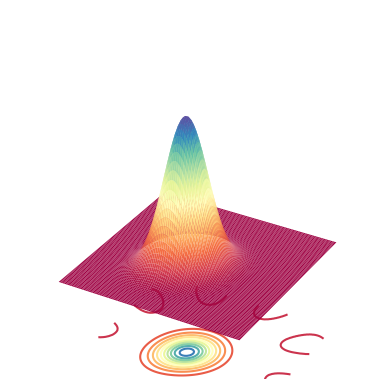

In [43]:
fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_target)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.1)
ax.set_axis_off()
plt.savefig("T.png")
fig.show()

Learn

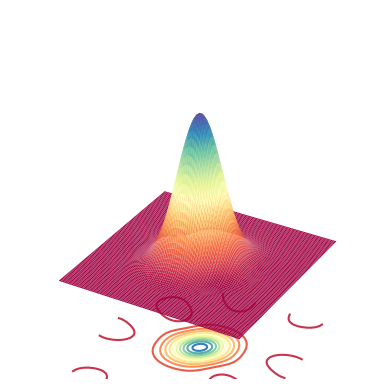

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
X, P, W = wigner(rho_learnt)
ax.plot_surface(X, P, W, cmap="Spectral", lw=0.5, rstride=1, cstride=1)
ax.contour(X, P, W, 10, cmap="Spectral", linestyles="solid", offset=-0.1) #0.2
ax.set_axis_off()
plt.savefig("L.png")
fig.show()

In [45]:
#Training state
ket

array([ 0.99661142+0.00044115j,  0.        -0.j        ,
       -0.01010138+0.07988948j,  0.        -0.j        ,
        0.00336894+0.0001332j ,  0.        -0.j        ,
        0.00417845-0.00866365j,  0.        -0.j        ,
       -0.00155992-0.00281928j])

In [46]:
#Quantum features map
QFM1

array([[ 9.41710616e-01+0.j        , -1.80872794e-01-0.24895004j,
        -3.80556944e-02+0.11712338j,  4.94088882e-02-0.01605392j,
        -1.81682259e-02-0.01319999j,  6.48317883e-18+0.00984528j,
         3.52406314e-03-0.00256038j, -1.84481199e-03-0.00059942j,
         2.68204391e-04+0.00082545j]])